# Dependencies

In [ ]:
!pip install keras==2.2.4
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 99kB/s 
     |████████████████████████████████| 491kB 44.2MB/s 
     |████████████████████████████████| 3.2MB 34.8MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


# Libraries

In [ ]:
import os
import sys
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
from keras.models import Sequential

seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = '/content/drive/MyDrive/painting/'

train_ids = next(os.walk(TRAIN_PATH))[2]

# Data Pre-Processing

In [ ]:
%%time
X_train = np.zeros((len(train_ids)-87, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
#        print(" Problem with: "+path)
        missing_count += 1

X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|██████████| 2129/2129 [00:49<00:00, 43.25it/s]


Total missing: 87
CPU times: user 46 s, sys: 43.6 s, total: 1min 29s
Wall time: 50.4 s


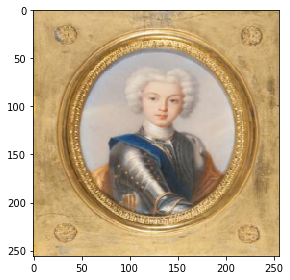

In [ ]:
imshow(X_train[8])
plt.show()

In [ ]:
x_train, x_test = train_test_split(X_train, test_size=20, random_state=seed)

# Transfer Learning

In [ ]:
inception = InceptionResNetV2(weights=None, include_top=True)
from tensorflow.keras.models import Sequential, load_model
# https://github.com/fchollet/deep-learning-models/releases/tag/v0.7 for downloading pretrained weights
inception.load_weights('/content/drive/MyDrive/Colab Notebooks/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5') 
inception.graph = tf.get_default_graph()

# Model Definition

In [ ]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 256, 256, 128 1280        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 128 0           conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 262272      max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_2

# Augmentation and Pre-Processing

In [ ]:
%%time

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

#Generate training data
def image_a_b_gen(dataset=x_train, batch_size = 20):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0] # grayscale layer, input of CNN
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128 # green-red, blue-yello, Output of CNN, /128 to normalize 'ab' colorspace
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch
        

CPU times: user 187 µs, sys: 35 µs, total: 222 µs
Wall time: 226 µs


# LR & Checkpoint

In [ ]:
# This is for checking at what learning rate the model should stop learning
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                             patience=3, 
                                             verbose=1, 
                                             factor=0.5,
                                             min_lr=0.00001)
filepath = "/content/drive/MyDrive/Image_Colorization_Model.h5"
checkpoint = ModelCheckpoint(filepath,
                              save_best_only=True,
                              monitor='loss',
                              mode='min')
model_callbacks = [learning_rate_reduction,checkpoint]

# Training with Data Generator

In [ ]:
#Run this part if need to train the model
BATCH_SIZE = 20
model.fit_generator(image_a_b_gen(X_train,BATCH_SIZE),
            epochs=25,
            verbose=1,
            steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
            callbacks=model_callbacks
            )

# Exporting Weights

In [ ]:
#This is for exporting the weights
model.save(filepath)
model.save_weights("Image_Colorization_Weights.h5")
inception.save(filepath)
inception.save_weights("Inception.h5")
from IPython.display import FileLink,FileLinks
import pickle 
FileLinks('.')

# Importing Weights

In [ ]:
model = Colorize()
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Image_Colorization_Weights.h5')

# Testing / Prediction

In [ ]:
sample = x_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128 #un-normalizing 'ab' layers

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))

# Results

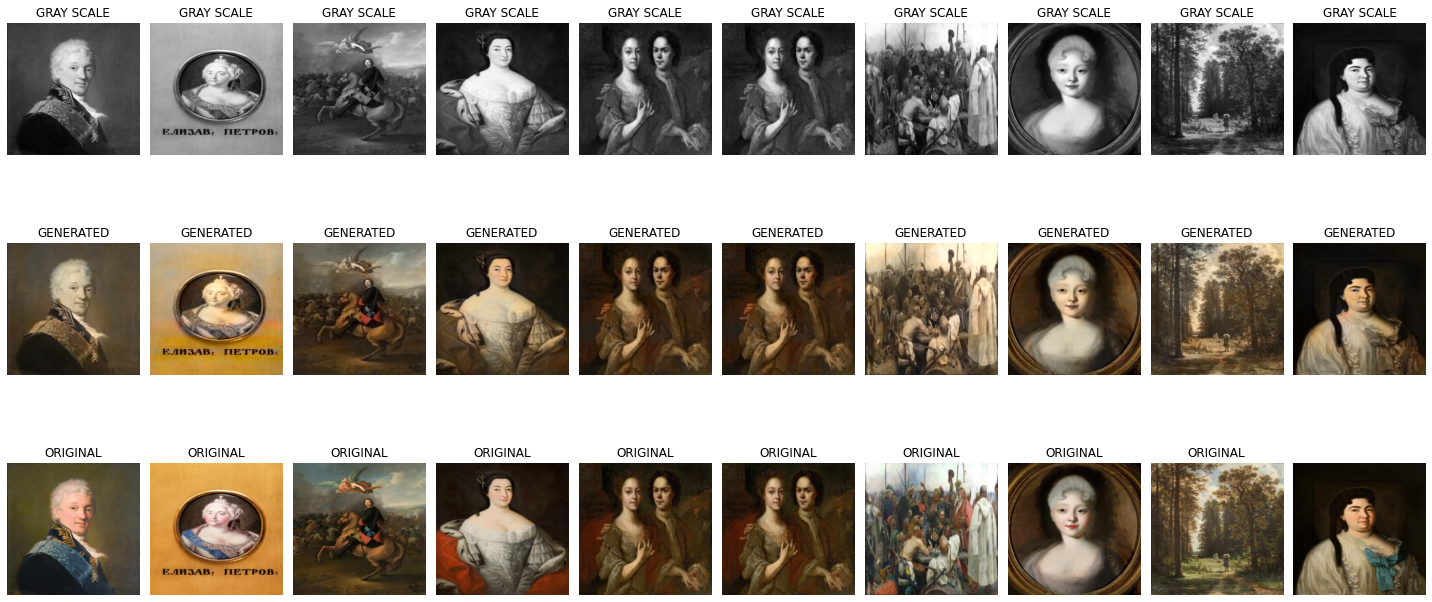

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(10):
    
    plt.title("ORIGINAL")
    plt.subplot(3, 10, i + 1)
    plt.imshow(rgb2gray(x_test)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
 
    
    plt.title("GRAY SCALE")
    plt.subplot(3, 10, i + 1 +10)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    
    
    plt.title("GENERATED")
    plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(x_test[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

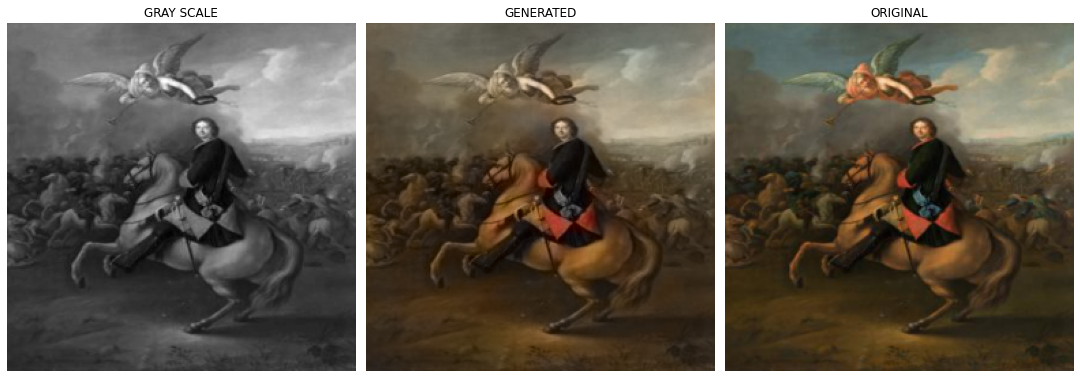

In [ ]:
i=2

#plt.title("RESULTS")
#plt.axis('off')
plt.figure(figsize=(50,10))

plt.subplot(1, 10,1)
plt.imshow(rgb2gray(x_test)[i].reshape(256, 256))
plt.gray()
plt.axis('off')

# recolorization
plt.title("GRAY SCALE")
plt.subplot(1, 10,2)
plt.imshow(decoded_imgs[i].reshape(256, 256,3))
plt.axis('off')

# original
plt.title("GENERATED")
plt.subplot(1, 10,3)
plt.imshow(x_test[i].reshape(256, 256,3))
plt.axis('off')

plt.title("ORIGINAL")

plt.tight_layout()
plt.show()